In [77]:
library(repr)


In [74]:
# Libraries
library(ggplot2) # plots
library(MCMCpack) # simple plots and effective sample size 
library(doParallel) # parallel computation
library(foreach) # prallel computation 
library(ggpubr)

Using the Metropolis-Hastings sampler you coded in Problem \ref{prob:mh-sampler},
    sample from the target distribution
    \begin{align*}
        \pi(x)
        =
        \cos^{2}(x) \times \cos^{2}(1.5x) \times \phi_{2}(x),
    \end{align*}
    where $\phi_{2}(\cdot)$ stands for the normal density $N(2,1)$.
    Use the proposal distribution 
    \begin{align*}
        q(x' \mid x)
        =
        \frac{1}{2\alpha}\mathbf{1}\set{x'\in\paren{x-\alpha, x+\alpha}}.
    \end{align*}

\begin{align}
\begin{aligned}
    \frac{\pi(x')}{\pi(x)}\frac{q(x\vert x')}{q(x'\vert x)} & =  \frac{\cos^{2}(x') \times \cos^{2}(1.5x') \times \phi_{2}(x')}{\cos^{2}(x) \times \cos^{2}(1.5x) \times \phi_{2}(x)}\frac{q(x\vert x')}{q(x\vert x)} \\
    &= \frac{\cos^{2}(x') \times \cos^{2}(1.5x')}{\cos^{2}(x) \times \cos^{2}(1.5x)}\exp\left(-\frac{1}{2}\left((x'-2)^2 - (x-2)^2\right)\right)\frac{q(x\vert x')}{q(x'\vert x)}
\end{aligned}
\end{align}

Take 
\begin{align}
    q(x'\vert x) = \frac{1}{2\alpha}\mathbf{1}\{x' \in [x - \alpha, x + \alpha]\}.
\end{align}
Notice that the proposal is symmetric -- i.e., $q(x'\vert x) = q(x\vert x') $ so that the acceptance ration simplifies to 
\begin{align}
\begin{aligned}
    \frac{\pi(x')}{\pi(x)}\frac{q(x\vert x')}{q(x'\vert x)} & =  \frac{\cos^{2}(x') \times \cos^{2}(1.5x')}{\cos^{2}(x) \times \cos^{2}(1.5x)}\exp\left(-\frac{1}{2}\left((x'-2)^2 - (x-2)^2\right)\right)
\end{aligned}
\end{align}

In [ ]:
# MH acceptance probability with uniform random walk proposal (symmetric)
p_accept <- function(x, y) {
  a <- exp(0.5*((x-2)^2-(y-2)^2)) * 
    ((cos(y)^2 * cos(1.5*y)^2) / (cos(x)^2 * cos(1.5*x)^2))
  return(min(1, a))
}#P_ACCEPT

In [92]:
alpha_list <- c(0.75, 4, 15)

# Run mcmc sampler for different values of alpha
x_mat <- matrix(0, N, length(alpha_list))
for(j in 1:length(alpha_list)) {
  x_mat[1, j] <- 10  
  for (i in 2:N) {
    u <- runif(1)
    y <- x_mat[i-1, j] + alpha_list[j]*(1-2*runif(1))
    if (u < p_accept(x_mat[i-1, j], y)) {
      x_mat[i, j] <- y
    } else {
      x_mat[i, j] <- x_mat[i-1, j]
    }#IFELSE
  }#FOR
}#FOR

In [ ]:
# Change plot size to 8 x 3
options(repr.plot.width=16, repr.plot.height=6)

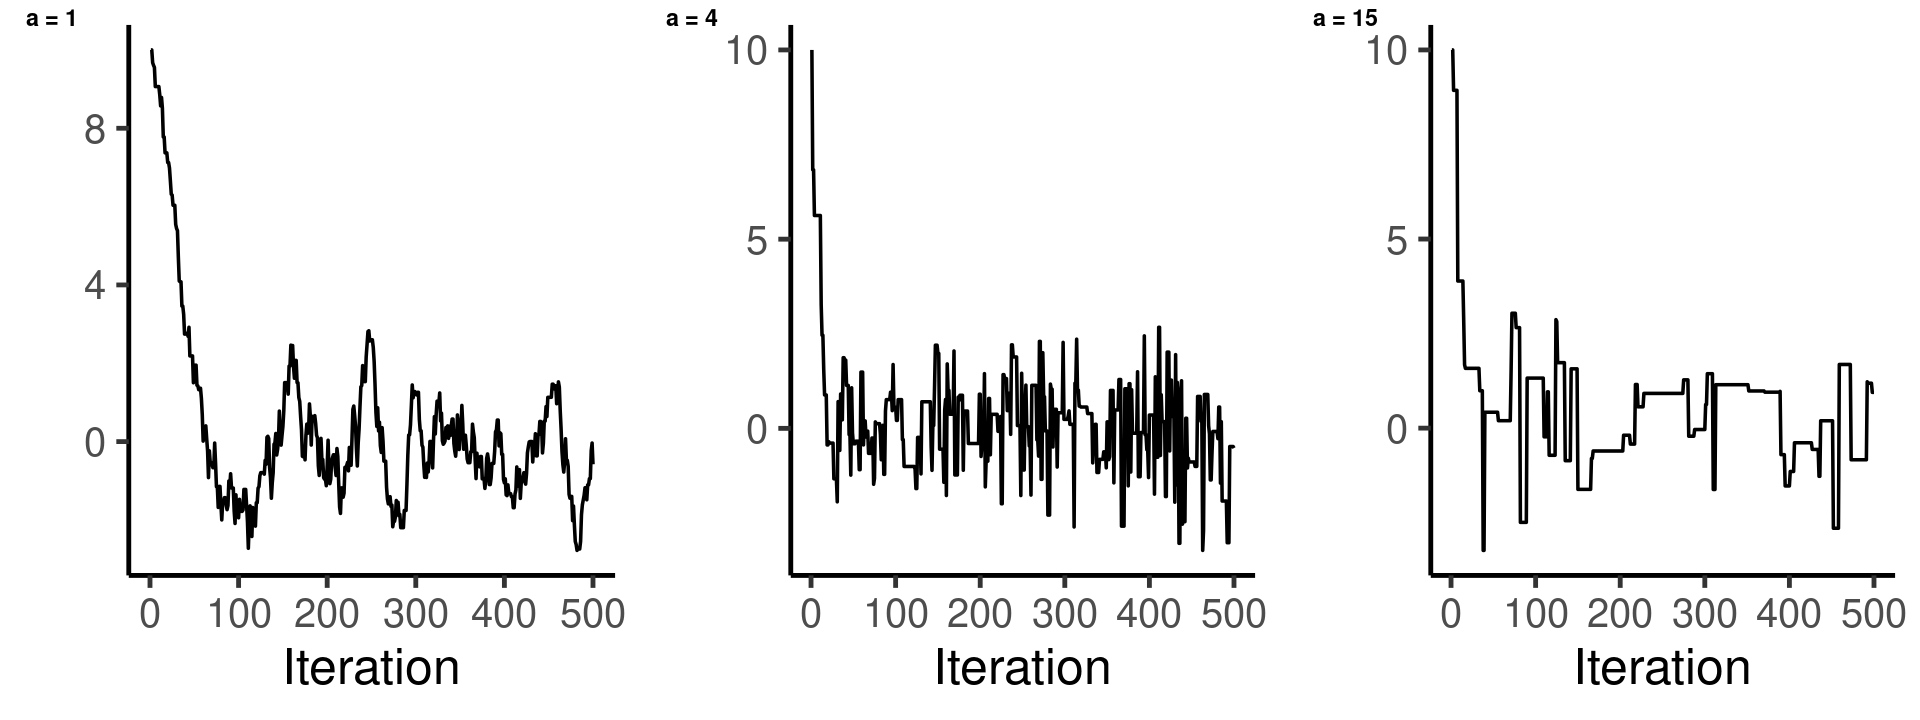

In [94]:
# Plot autocorrelations 
plt_list <- list(NULL)
for (j in 1:3) {
    df <- data.frame(t = c(1:500), X = x_mat[1:500, j])
    plt_list[[j]] <- ggplot(data = df, aes(x = t, y = X)) + 
    geom_line(size = 1) +
    ylab("") +
    xlab("Iteration") +
    theme_classic(base_size = 30)      
}#FOR
ggarrange(plt_list[[1]], plt_list[[2]], plt_list[[3]], nrow = 1, labels = c("a = 1", "a = 4", "a = 15"))

In [95]:
# Acceptance rate
apply(x_mat, 2, function(x){length(unique(x))/N})

[1] 0.8484 0.3986 0.1022

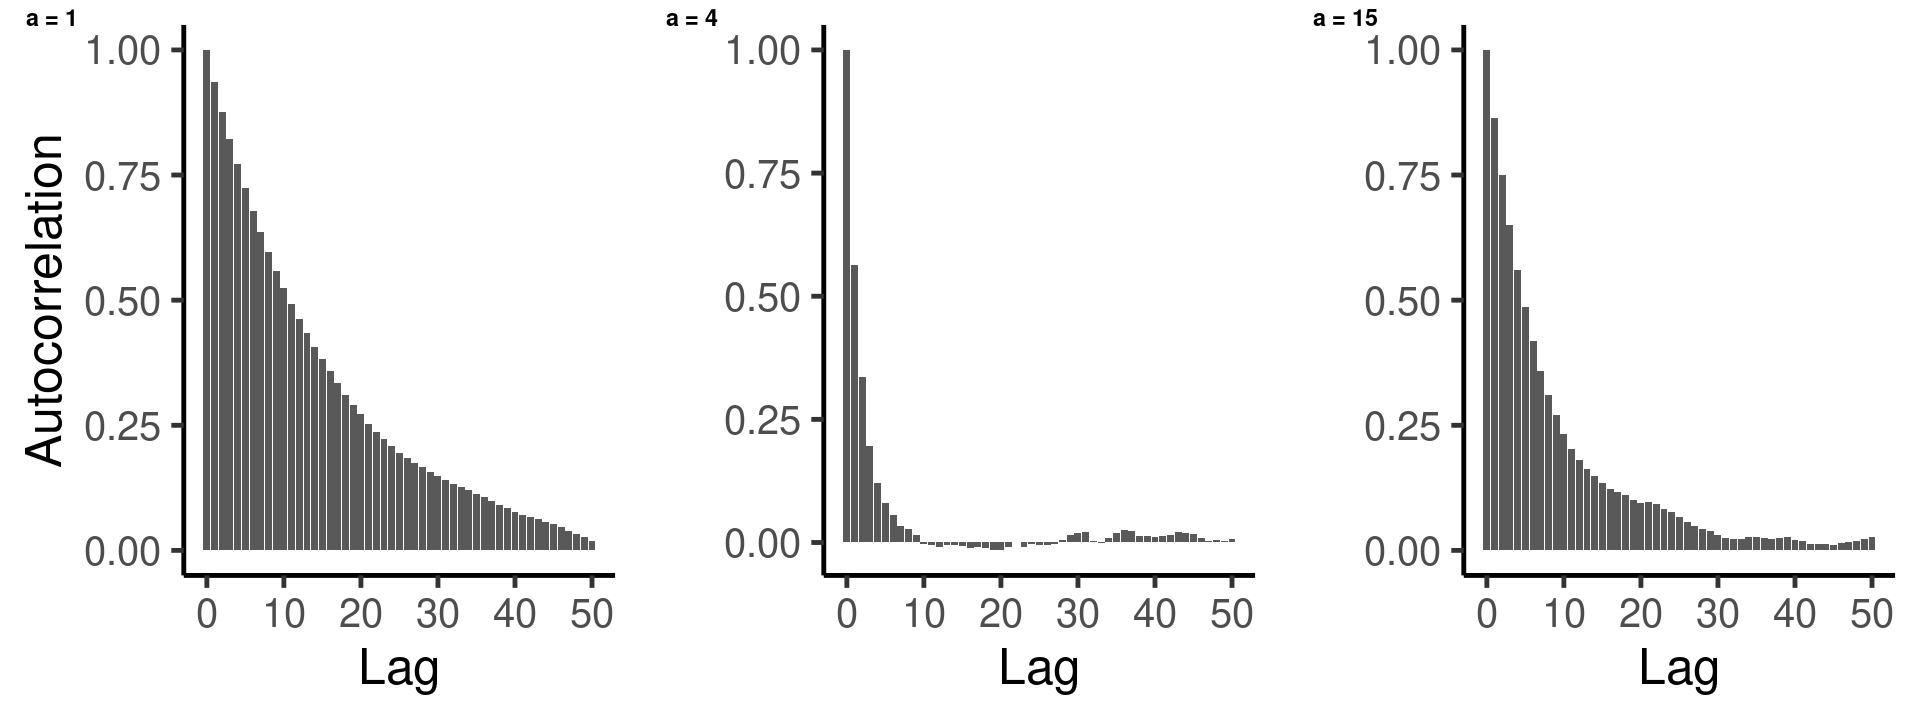

In [93]:
# Plot autocorrelations 
plt_list <- list(NULL)
for (j in 1:3) {
    acf_j <- acf(x_mat[, j], lag.max = 50, type = "correlation", plot = F)$acf
    plt_list[[j]] <- ggplot(data = data.frame(lag = c(0:50), acf = acf_j), 
              aes(x = lag, y = acf)) + 
      geom_bar(stat = "identity") +
      ylab("") +
      xlab("Lag") +
      theme_classic(base_size = 30)
    if (j == 1) plt_list[[j]] <- plt_list[[j]] + ylab("Autocorrelation")
      
}#FOR
ggarrange(plt_list[[1]], plt_list[[2]], plt_list[[3]], nrow = 1, labels = c("a = 1", "a = 4", "a = 15"))

In [96]:
# Check effective sample size
effectiveSize(as.mcmc(x_mat))

var1      var2      var3 
 334.2668 2637.2148  726.3885

The considered proposal distribution is a uniform random walk with increments distributed as $U(-\alpha, \alpha)$. Therefore, a larger $\alpha$ will result in greater variance of the proposals. This has two primary effects. On one hand, proposals further apart allow the chain to more easily jump between modes of the target distribution, benefiting exploration. On the other hand, far-off proposals may notably reduce the acceptance probability, reducing mixing. Lower $\alpha$ may also benefit mixing within each mode.

To illustrate this trade-off, I consider samplers with $\alpha \in \{1, 4, 10\}$.The acceptance rates are 0.516, 0.286, and 0.138, respectively. Figure \ref{fig:mcmc-output-analysis} provides the trace and autocorrelation plots for a chain with $N=1000$ iterations.

Focusing first on the trace plots in the left panels of Figure \ref{fig:mcmc-output-analysis}, we see that for $\alpha = 1$, the chain has a considerably larger burn-in period and only infrequently transitions between modes of the distributions. While allowing for good mixing within modes, the small steps also induce very high autocorrelations. For $\alpha = 10$, the chain frequently switches between modes but is also often ``stuck'' at a particular value for a considerable number of iterations and does therefore not mix well within each mode. A suitable compromise between the two extremes appears to be $\alpha = 4$. It frequently transitions between modes, yet, with an acceptance rate of 0.286, is not ``stuck'' as frequently. The quickly decreasing autocorrelations further indicate that the chain mixes well.

The sampling distributions for each sampler are presented in Figure \ref{fig:sampling-1000} ($N=1000$) and Figure \ref{fig:sampling-10000} ($N=10,000$). Because this is an illustrative example, I have not removed a burn-in period or thinned the samples. Focusing first on Figure \ref{fig:sampling-1000}, we see that -- in line with expectations -- the sampling distribution for $\alpha=1$ appears to mix well within each mode, yet, appears to distort the proportion of each mode in the total distribution. For $\alpha=10$, the proportion of each mode is better approximated, yet, a few values with very high values at which the chain was stuck for many iterations stand out. A reasonable middle ground is provided by panel (b), which appears to better mirror the target distribution within modes than panel (c) and better across modes than panel (a).

Note that the issues discussed here concern convergence rates. With sufficiently many draws, the samplers result in very similar posterior density estimates (see Figure \ref{fig:sampling-10000}).

In [101]:
# Data Simulation ==============================================================

# Set true parameter values
true_beta = matrix(c(1:4), 4, 1)
true_sgm2_b = 3
true_sgm2_e = 3

# Simulate data
nobs = 100 # number of observations
X <- array(rnorm(2*4*nobs, 0, 1), dim = c(2, 4, nobs))
W <- matrix(rnorm(2*nobs, 0, 1), 2, nobs)
y <- matrix(0, 2, nobs)
for(i in 1:nobs) {
  y[, i] <- X[, , i] %*% true_beta + W[, i] * rnorm(2, 0, sqrt(true_sgm2_b)) + 
    rnorm(2, 0, sqrt(true_sgm2_e))
}#FOR 

In [102]:
# Likelihood Functions =========================================================

# log-likelihood
get_logl <- function(y, X, W, beta, sgm2_b, sgm2_e) {
  # Get diagonal covariance terms 
  mat_Sigmas <- apply(W, 2, function(x){ x^2 * sgm2_b + sgm2_e })
  
  # Compute determinants of Sigma_i
  mat_det <- apply(mat_Sigmas, 2, function(x){ sqrt(x[1] * x[2]) })

  # Compute scaled squared deviations
  err <- y - apply(X, c(3), function(x){ x %*% beta })
  sq_devs <- matrix(0, ncol(y), 1)
  for(i in 1:ncol(y)) {
    sq_devs[i] <- t(err[, i]) %*% diag(1/mat_Sigmas[, i]) %*% err[, i]
  }#FOR
  
  # Calculate and return log likelihood
  logl <- -sum(log(mat_det)) - 0.5 * sum(sq_devs)
  return(logl)
}#GET_LOGL

# log posterior
get_logtarget <- function(beta, sgm2_b, sgm2_e,
                          y, X, W, 
                          mu, Sgm_beta,
                          lambda_b, gamma_b, 
                          lambda_e, gamma_e) {
  get_logl(y, X, W, beta, sgm2_b, sgm2_e) + 
    dnorm(beta, mu, sqrt(diag(Sgm_beta)), log = T) + 
    dgamma(1/sgm2_b, lambda_b*gamma_b, gamma_b, log = T) + 
    dgamma(1/sgm2_e, lambda_b*gamma_b, gamma_b, log = T)
}#GET_LOGTARGET

In [103]:
# MH Functions ===========================================================

# Propose new 1/sgm2_j (asymmetric!)
proposal_sgm2_inv <- function(sgm2_inv_old, q_sgm_gamma = 1) {
  sgm2_inv_new <- rgamma(1, sgm2_inv_old * q_sgm_gamma, q_sgm_gamma)
  lq_forward <- dgamma(sgm2_inv_new, sgm2_inv_old * q_sgm_gamma, q_sgm_gamma, 
                      log = T)
  lq_backward <- dgamma(sgm2_inv_old, sgm2_inv_new * q_sgm_gamma, q_sgm_gamma, 
                        log = T)
  return(list(new = sgm2_inv_new, 
              lq_forward = lq_forward, lq_backward = lq_backward))
}#PROPOSAL_SGM2_INV

# MH acceptance  
acceptreject <- function(beta_new, sgm2_b_new, sgm2_e_new,
                     beta_old, sgm2_b_old, sgm2_e_old,
                     lq_forward, lq_backward,
                     y, X, W, mu, Sgm_beta, 
                     lambda_b, gamma_b, lambda_e, gamma_e) {
  # calculate alpha 
  log_alpha <-  get_logtarget(beta_new, sgm2_b_new, sgm2_e_new,
                          y, X, W, mu, Sgm_beta, 
                          lambda_b, gamma_b, lambda_e, gamma_e) -
    get_logtarget(beta_old, sgm2_b_old, sgm2_e_old,
                  y, X, W, mu, Sgm_beta, 
                  lambda_b, gamma_b, lambda_e, gamma_e) +
    lq_backward -
    lq_forward
  # Accept randomly
  accept <- log(runif(1)) < min(0, log_alpha)
  return(accept)
}#ACCEPTREJECT


In [106]:
# Prior Specification ==========================================================

# Prior hyperparameters
# prior on beta
mu = rep(0, 4)
Sgm_beta = diag(rep(1, 4)) * 10 #  the higher, the less "informative"

#prior on precision 1/sgm2_j
lambda_b = lambda_e = 1 # the lower, the lower the expected precision
gamma_b = gamma_e = 0.5 # the lower, the less "informative"

In [114]:
# MH-MCMC ======================================================================

# Hyperparameters
nsim <- 10000 # iterations per chain
nchains <- 10

# Parallelization setup
ncores <- parallel::detectCores(logical = F) - 1 
cl <- parallel::makeCluster(ncores, outfile="")
doParallel::registerDoParallel(cl, cores = ncores)
parallel::clusterExport(cl, c("y", "X", "W"),
                        envir = environment())
parallel::clusterExport(cl, c("get_logl", "get_logtarget", 
                              "proposal_sgm2_inv", "acceptreject"),
                        envir = environment())

# Run mcmc chains in parallel
mcmc_res <- foreach::foreach(x = 1:nchains) %dopar% {
  # Initialize parameter matrix w/ prior expectation + noise
  theta_mat <- matrix(0, nsim, 6)
  theta_mat[1, ] <- c(mu, lambda_b, lambda_e) # prior expectation
  theta_mat[1, 1:4] <- theta_mat[1, 1:4] + rnorm(4, 0, 2) # add noise
  theta_mat[1, 5:6] <- theta_mat[1, 5:6] + 
    0.25 * c(lambda_b, lambda_e) * (1 - 2*runif(2))
    
  # Run sequential scan MH-MCMC
  for(i in 2:nsim){
    
    # Draw new proposals
    which_par <- sample(1:3, 1)
    if(which_par == 1) {
      # Update a random subset of the betas (random scan)
      which_beta <- sample(c(1:4), sample(c(1:4), 1))
      beta_new <- theta_mat[i-1, 1:4]
      beta_new[which_beta] <- theta_mat[i-1, which_beta] + 
        0.1*(1-2*runif(length(which_beta)))
      lq_forward <- lq_backward <- 0
      # Copy values for sgm2_j
      sgm2_b_new <- theta_mat[i-1, 5]; sgm2_e_new <- theta_mat[i-1, 6]
    } else if (which_par == 2) {
      # Update sgm2_b
      sgm2_b_prop <- proposal_sgm2_inv(1/theta_mat[i-1, 5], q_sgm_gamma = 50)
      sgm2_b_new <- 1/sgm2_b_prop$new;
      lq_forward <- sgm2_b_prop$lq_forward
      lq_backward <- sgm2_b_prop$lq_backward
      # Copy values for beta and sgm2_e
      beta_new <- theta_mat[i-1, 1:4]; sgm2_e_new <- theta_mat[i-1, 6]
    } else {
      # Update sgm2_e
      sgm2_e_prop <- proposal_sgm2_inv(1/theta_mat[i-1, 6], q_sgm_gamma = 50)
      sgm2_e_new <- 1/sgm2_e_prop$new;
      lq_forward <- sgm2_e_prop$lq_forward
      lq_backward <- sgm2_e_prop$lq_backward
      # Copy values for beta and sgm2_b
      beta_new <- theta_mat[i-1, 1:4]; sgm2_b_new <- theta_mat[i-1, 5]
    }#IFELSE
    
    # Check for acceptance
    accept <- acceptreject(beta_new, sgm2_b_new, sgm2_e_new,
                           theta_mat[i-1, 1:4], 
                           theta_mat[i-1, 5], theta_mat[i-1, 6],
                           lq_forward, lq_backward,
                           y, X, W, mu, Sgm_beta, 
                           lambda_b, gamma_b, lambda_e, gamma_e)
    
    # Update chain
    if(accept) {
      theta_mat[i, 1:4] <- beta_new
      theta_mat[i, 5] <- sgm2_b_new
      theta_mat[i, 6] <- sgm2_e_new
    } else {
      theta_mat[i, 1:4] <- theta_mat[i-1, 1:4]
      theta_mat[i, 5] <- theta_mat[i-1, 5]
      theta_mat[i, 6] <- theta_mat[i-1, 6]
    }#IFELSE
  }#FOR
  
  # Return natrix of samples
  return(theta_mat)
}#FOREACH
  
# Terminate all parrallel clusters
parallel::stopCluster(cl)

In [116]:
# MCMC trace
plt_trace <- list(NULL)
for (i in 1:6) {
  # Get samples by parameter
  theta_i <- sapply(mcmc_res, function(x){x[, i]})
  if(i >= 5) theta_i <-1/theta_i # transform var to precision

  # Superficial convergence analysis (pre thinning)
  df <- data.frame(t = c(1:nrow(theta_i)), Chain = theta_i)
  # Plot trace of combined chains
  plt_trace[[i]] <- ggplot(data = df[1:10000, ], aes(x = t)) + 
    ylab("") +
    xlab("Iteration") +
    theme_classic(base_size = 30)
  for(j in 3:ncol(df)) {
    plt_trace[[i]] <- plt_trace[[i]] + geom_line(aes_string(y = df[1:10000,j]), size = 0.5, 
                           colour="#999999")
  }  
  plt_trace[[i]] <- plt_trace[[i]] + 
    geom_vline(aes(xintercept=3000), size = 1, linetype  = "dashed") +
    geom_line(aes_string(y = df[1:10000, 2]), size = 1)  
}#FOR

In [120]:
# Change plot size to 8 x 3
options(repr.plot.width=16, repr.plot.height=18)

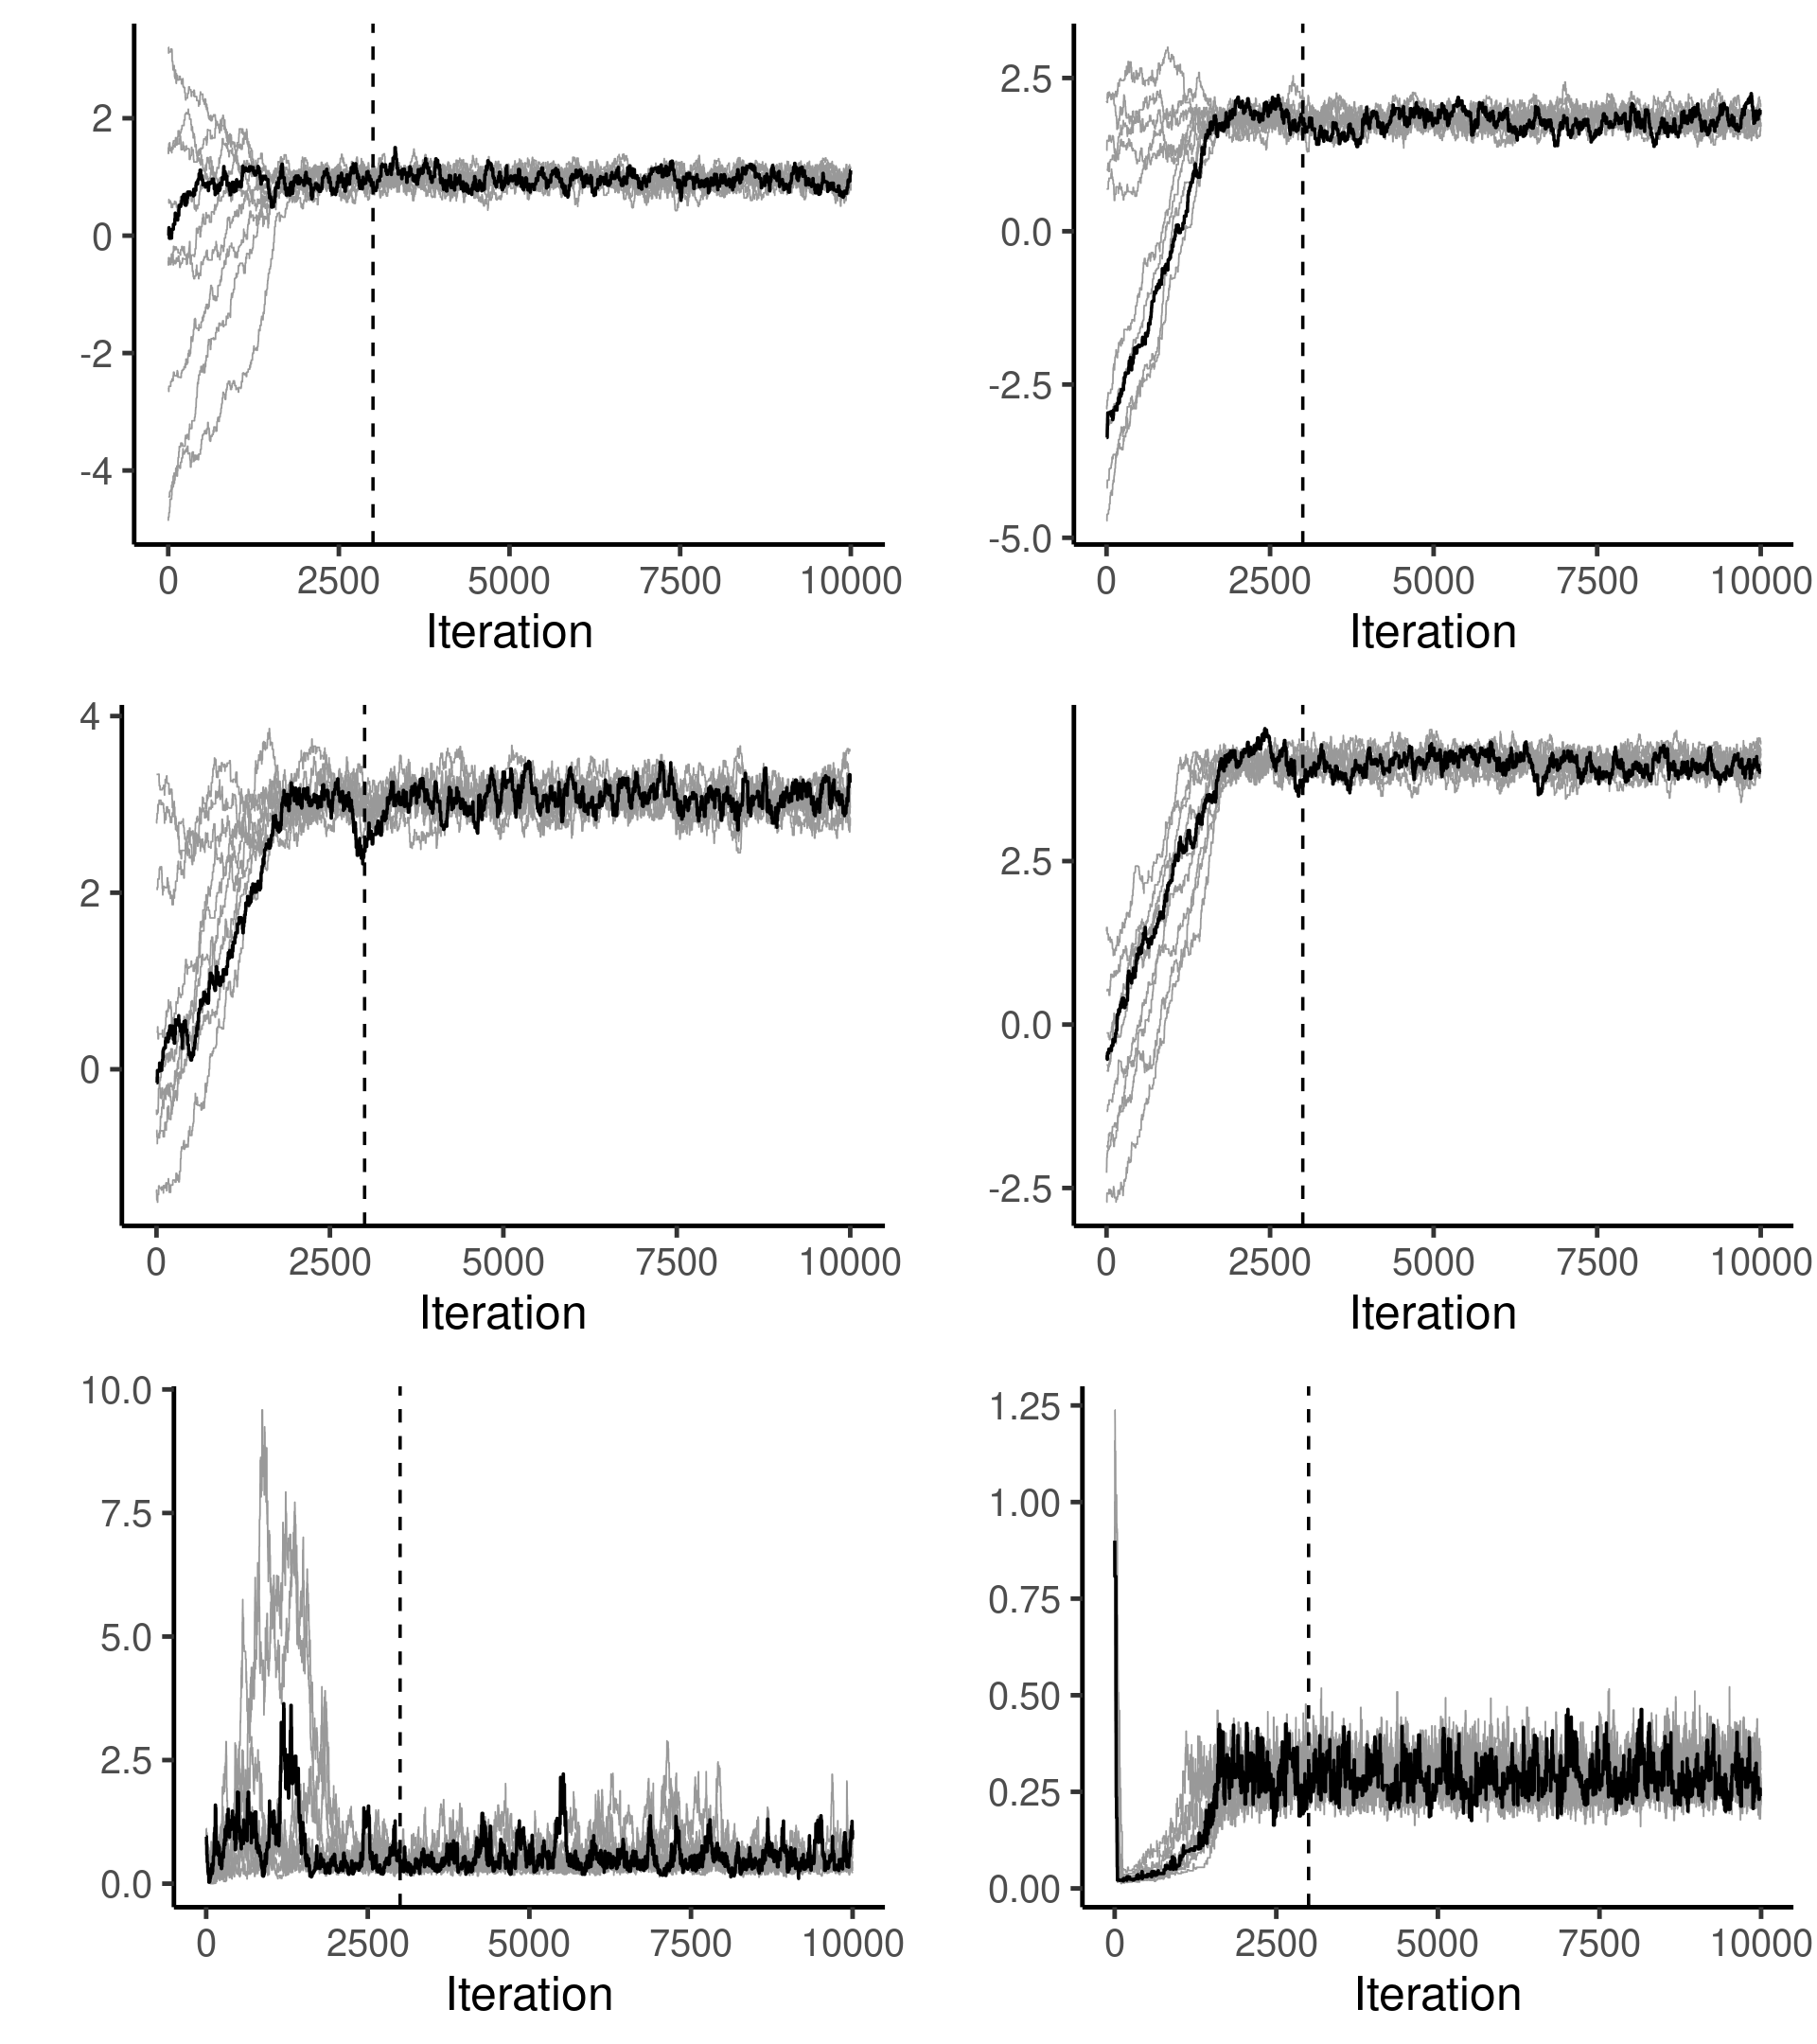

In [122]:
ggarrange(plt_trace[[1]], plt_trace[[2]], plt_trace[[3]], 
          plt_trace[[4]], plt_trace[[5]], plt_trace[[6]],
          nrow = 3, ncol = 2)

In [132]:
# Calculate acceptance rates
mean(sapply(mcmc_res, function(x){nrow(unique(x))/nsim}))

[1] 0.67745

In [123]:
# ACF
plt_acf <- list(NULL)
for (i in 1:6) {
  # Get samples by parameter
  theta_i <- sapply(mcmc_res, function(x){x[, i]})
  if(i >= 5) theta_i <-1/theta_i # transform var to precision

  # Plot autocorrelations (pre thinning)
  acf_mat <- acf(theta_i, lag.max = 50, type = "correlation", plot = F)
  acf_i <- apply(sapply(c(1:nchains), function(x){acf_mat$acf[,x, x]}), 1, mean)
  plt_acf[[i]] <- ggplot(data = data.frame(lag = c(0:50), acf = acf_i), 
                aes(x = lag, y = acf)) + 
    geom_bar(stat = "identity") +
    ylab("Autocorrelation") +
    xlab("Lag") +
    theme_classic(base_size = 30) 
}#FOR

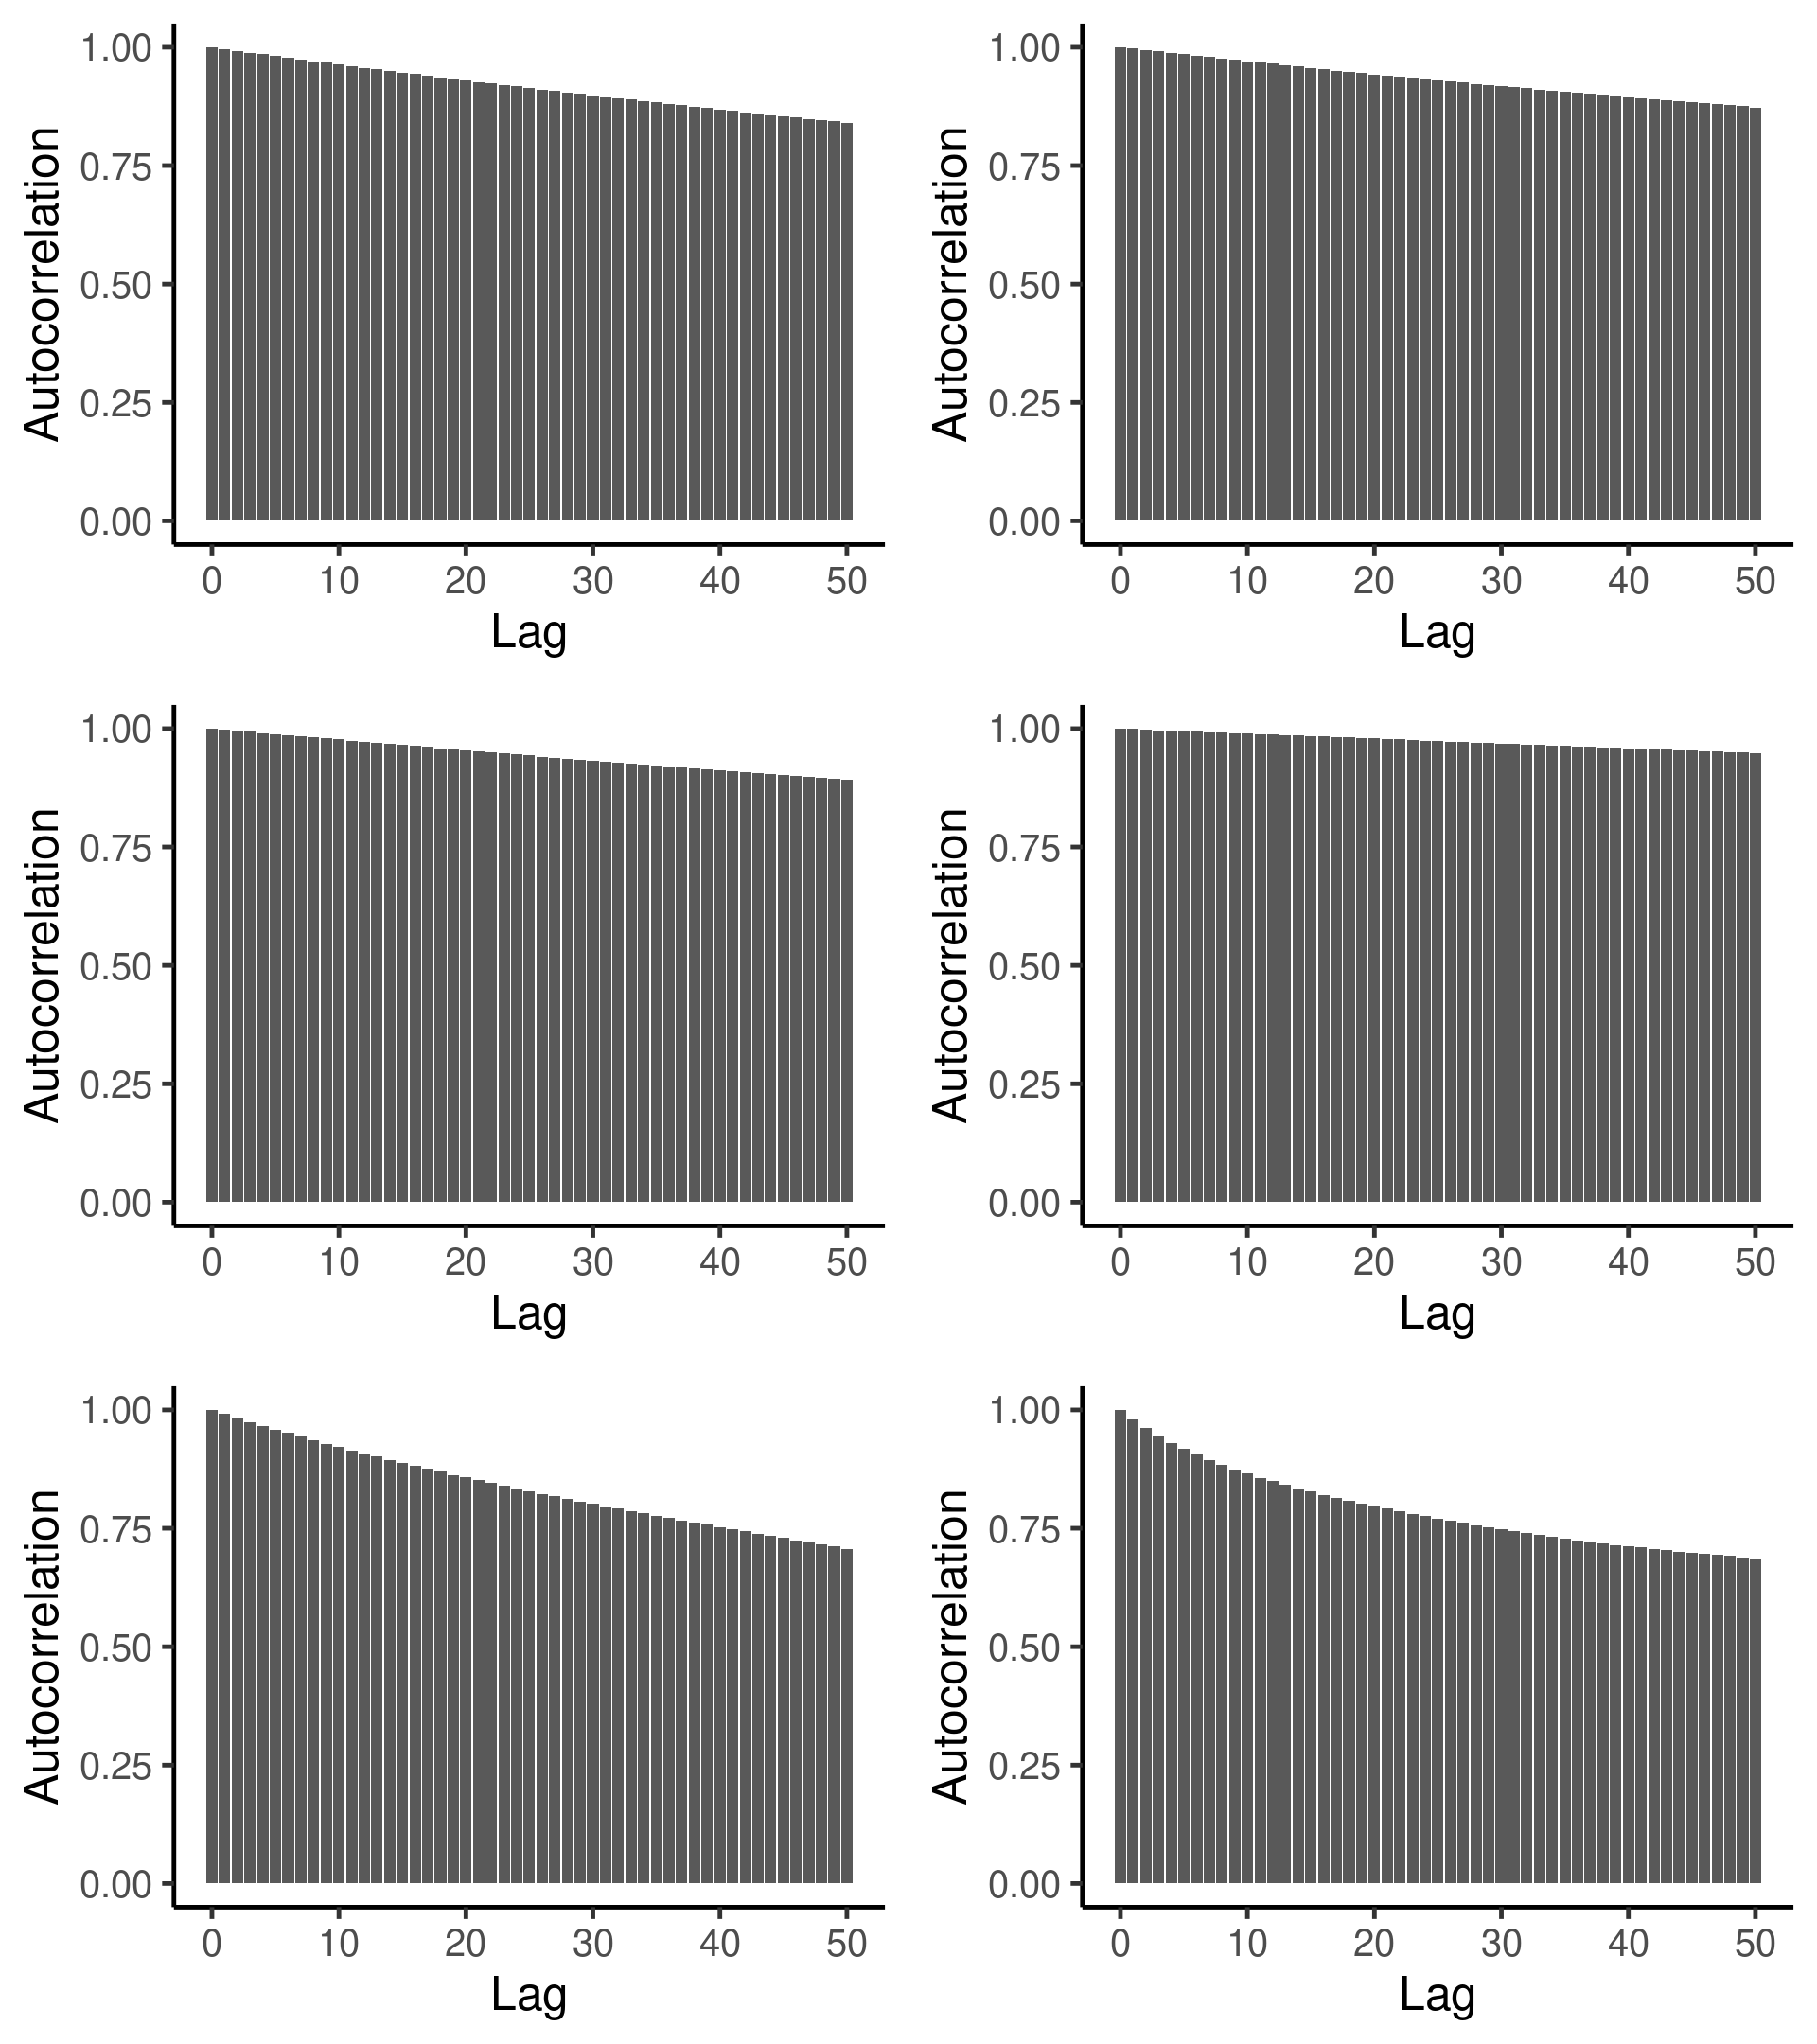

In [124]:
ggarrange(plt_acf[[1]], plt_acf[[2]], plt_acf[[3]], 
          plt_acf[[4]], plt_acf[[5]], plt_acf[[6]],
          nrow = 3, ncol = 2)

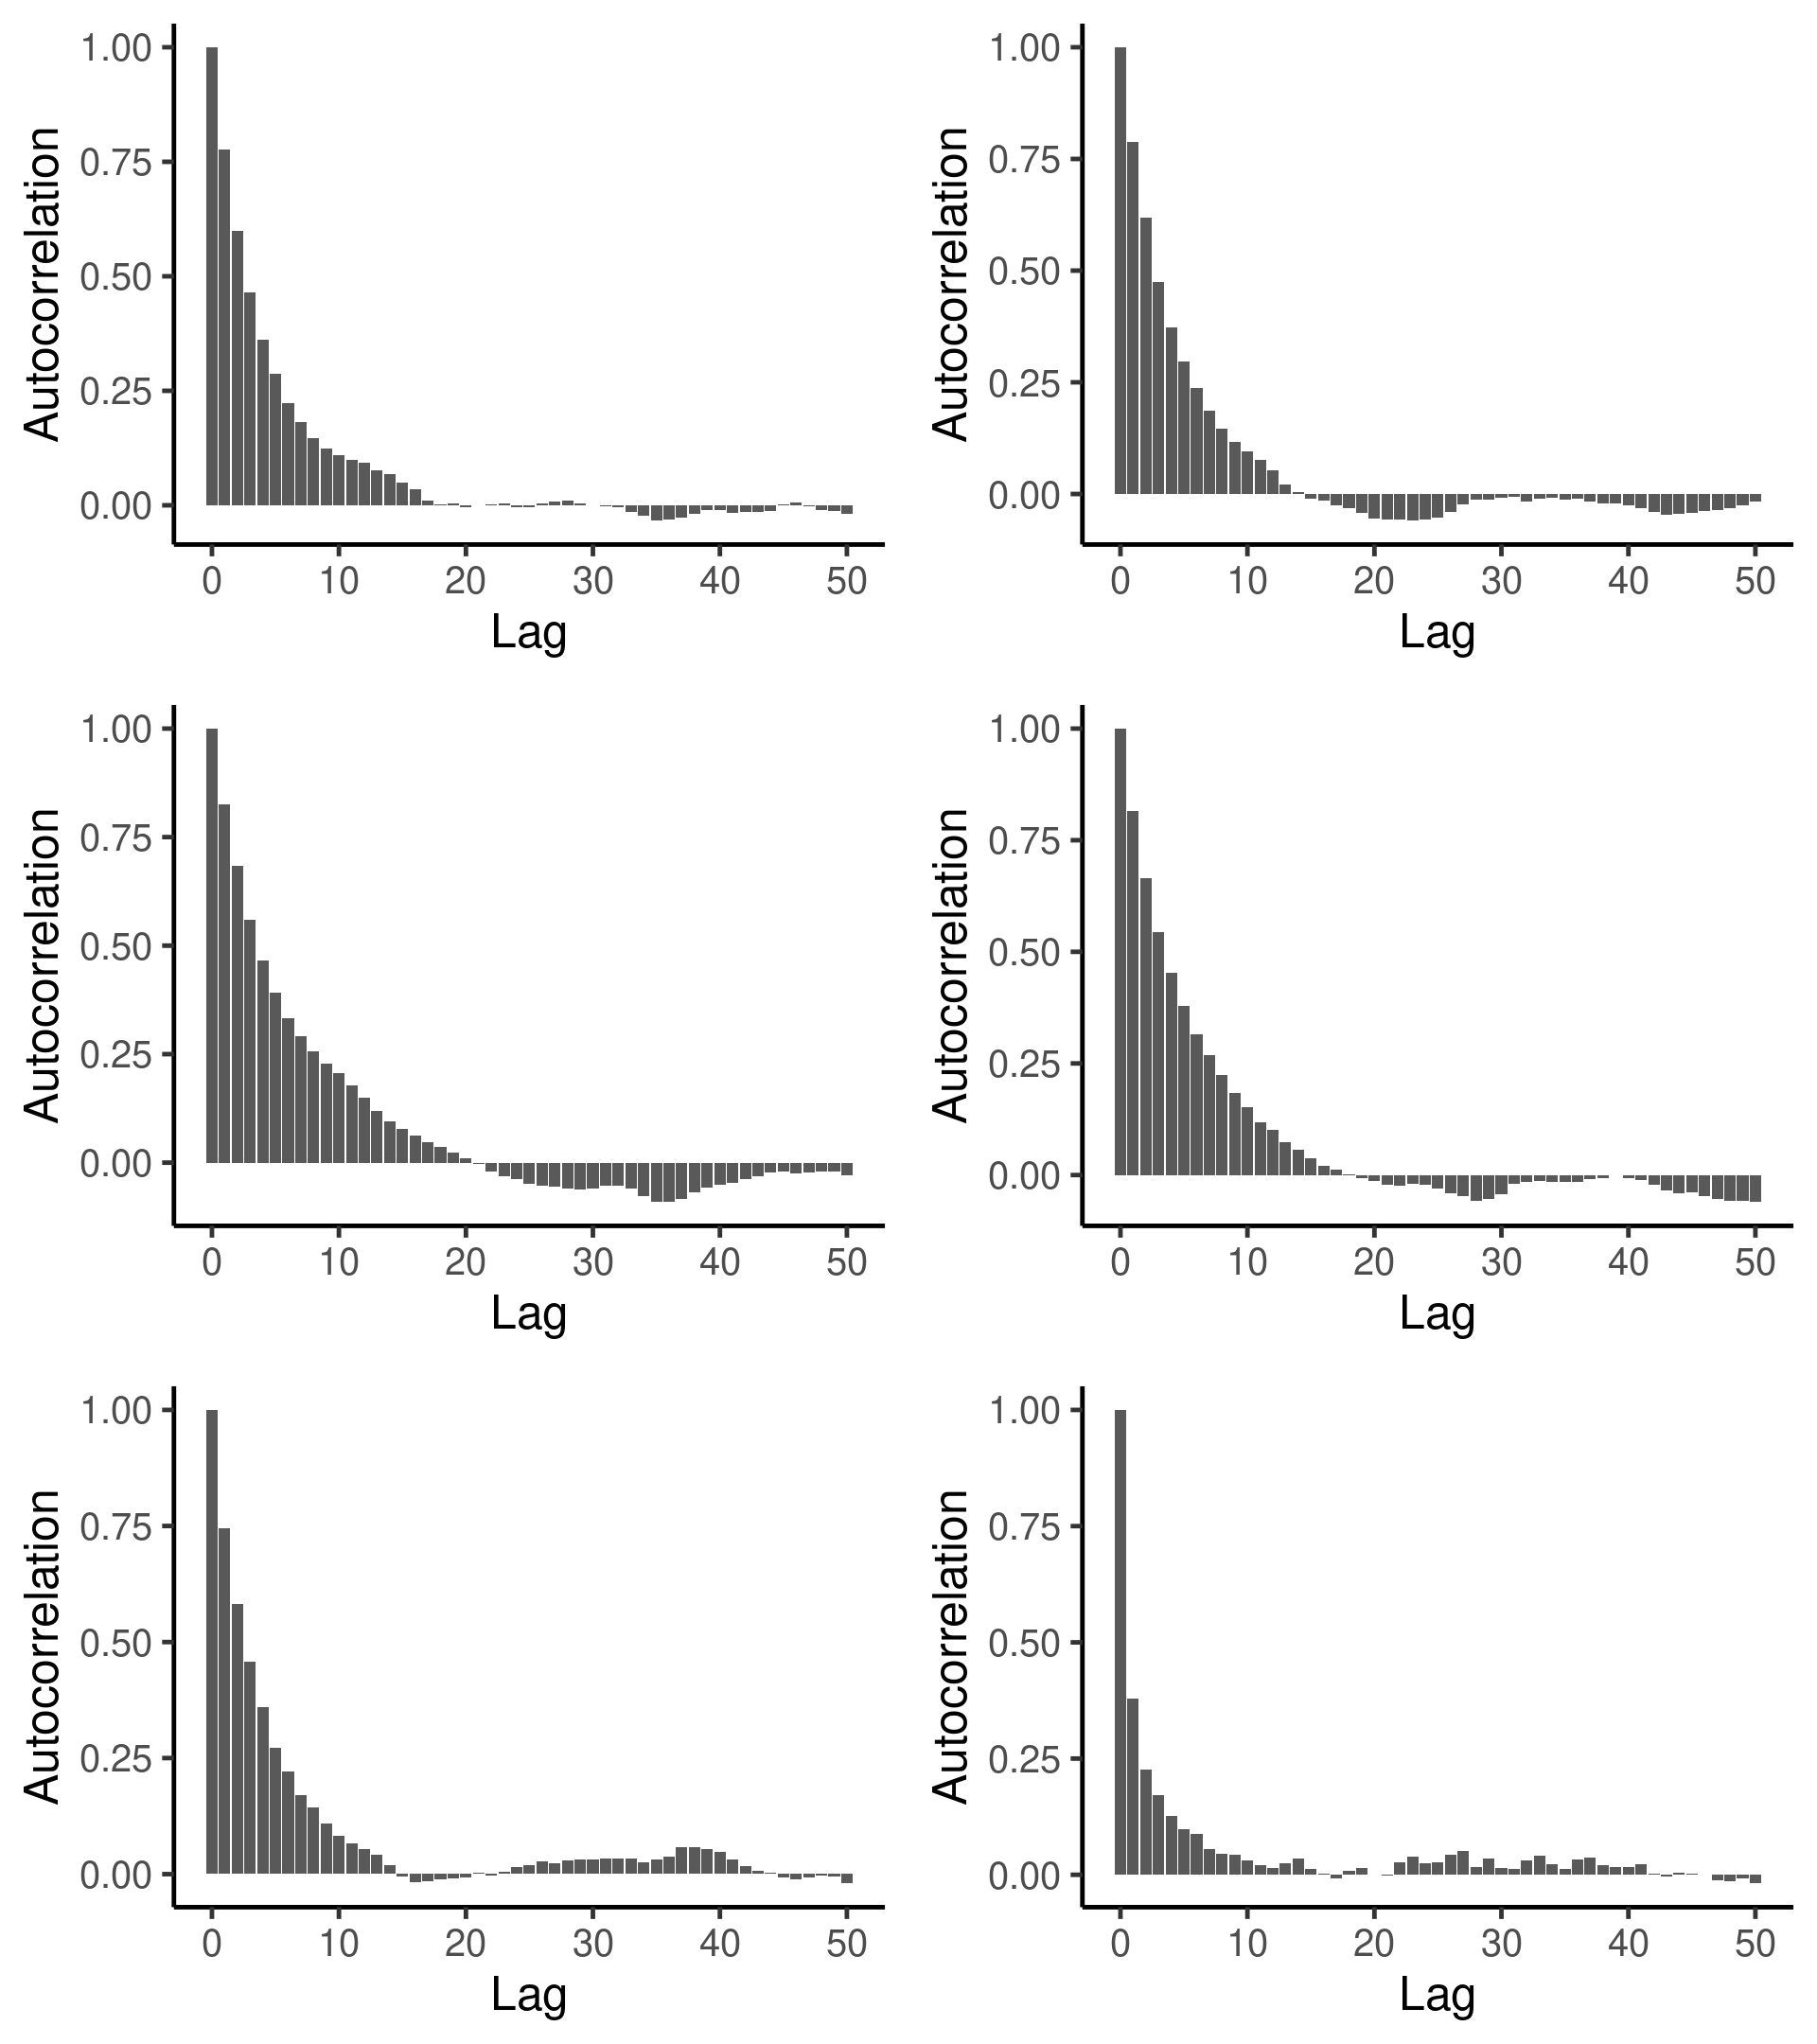

In [127]:
# ACF
plt_acf <- list(NULL)
for (i in 1:6) {
  # Get samples by parameter
  theta_i <- sapply(mcmc_res, function(x){x[, i]})
  if(i >= 5) theta_i <-1/theta_i # transform var to precision
    
  # Remove burn-in and thin samples
  theta_i <- theta_i[3000:nrow(theta_i), ]
  theta_i <- theta_i[seq(1, nrow(theta_i), 20), ] # Every 50th sample

  # Plot autocorrelations (pre thinning)
  acf_mat <- acf(theta_i, lag.max = 50, type = "correlation", plot = F)
  acf_i <- apply(sapply(c(1:nchains), function(x){acf_mat$acf[,x, x]}), 1, mean)
  plt_acf[[i]] <- ggplot(data = data.frame(lag = c(0:50), acf = acf_i), 
                aes(x = lag, y = acf)) + 
    geom_bar(stat = "identity") +
    ylab("Autocorrelation") +
    xlab("Lag") +
    theme_classic(base_size = 30) 
}#FOR

ggarrange(plt_acf[[1]], plt_acf[[2]], plt_acf[[3]], 
          plt_acf[[4]], plt_acf[[5]], plt_acf[[6]],
          nrow = 3, ncol = 2)

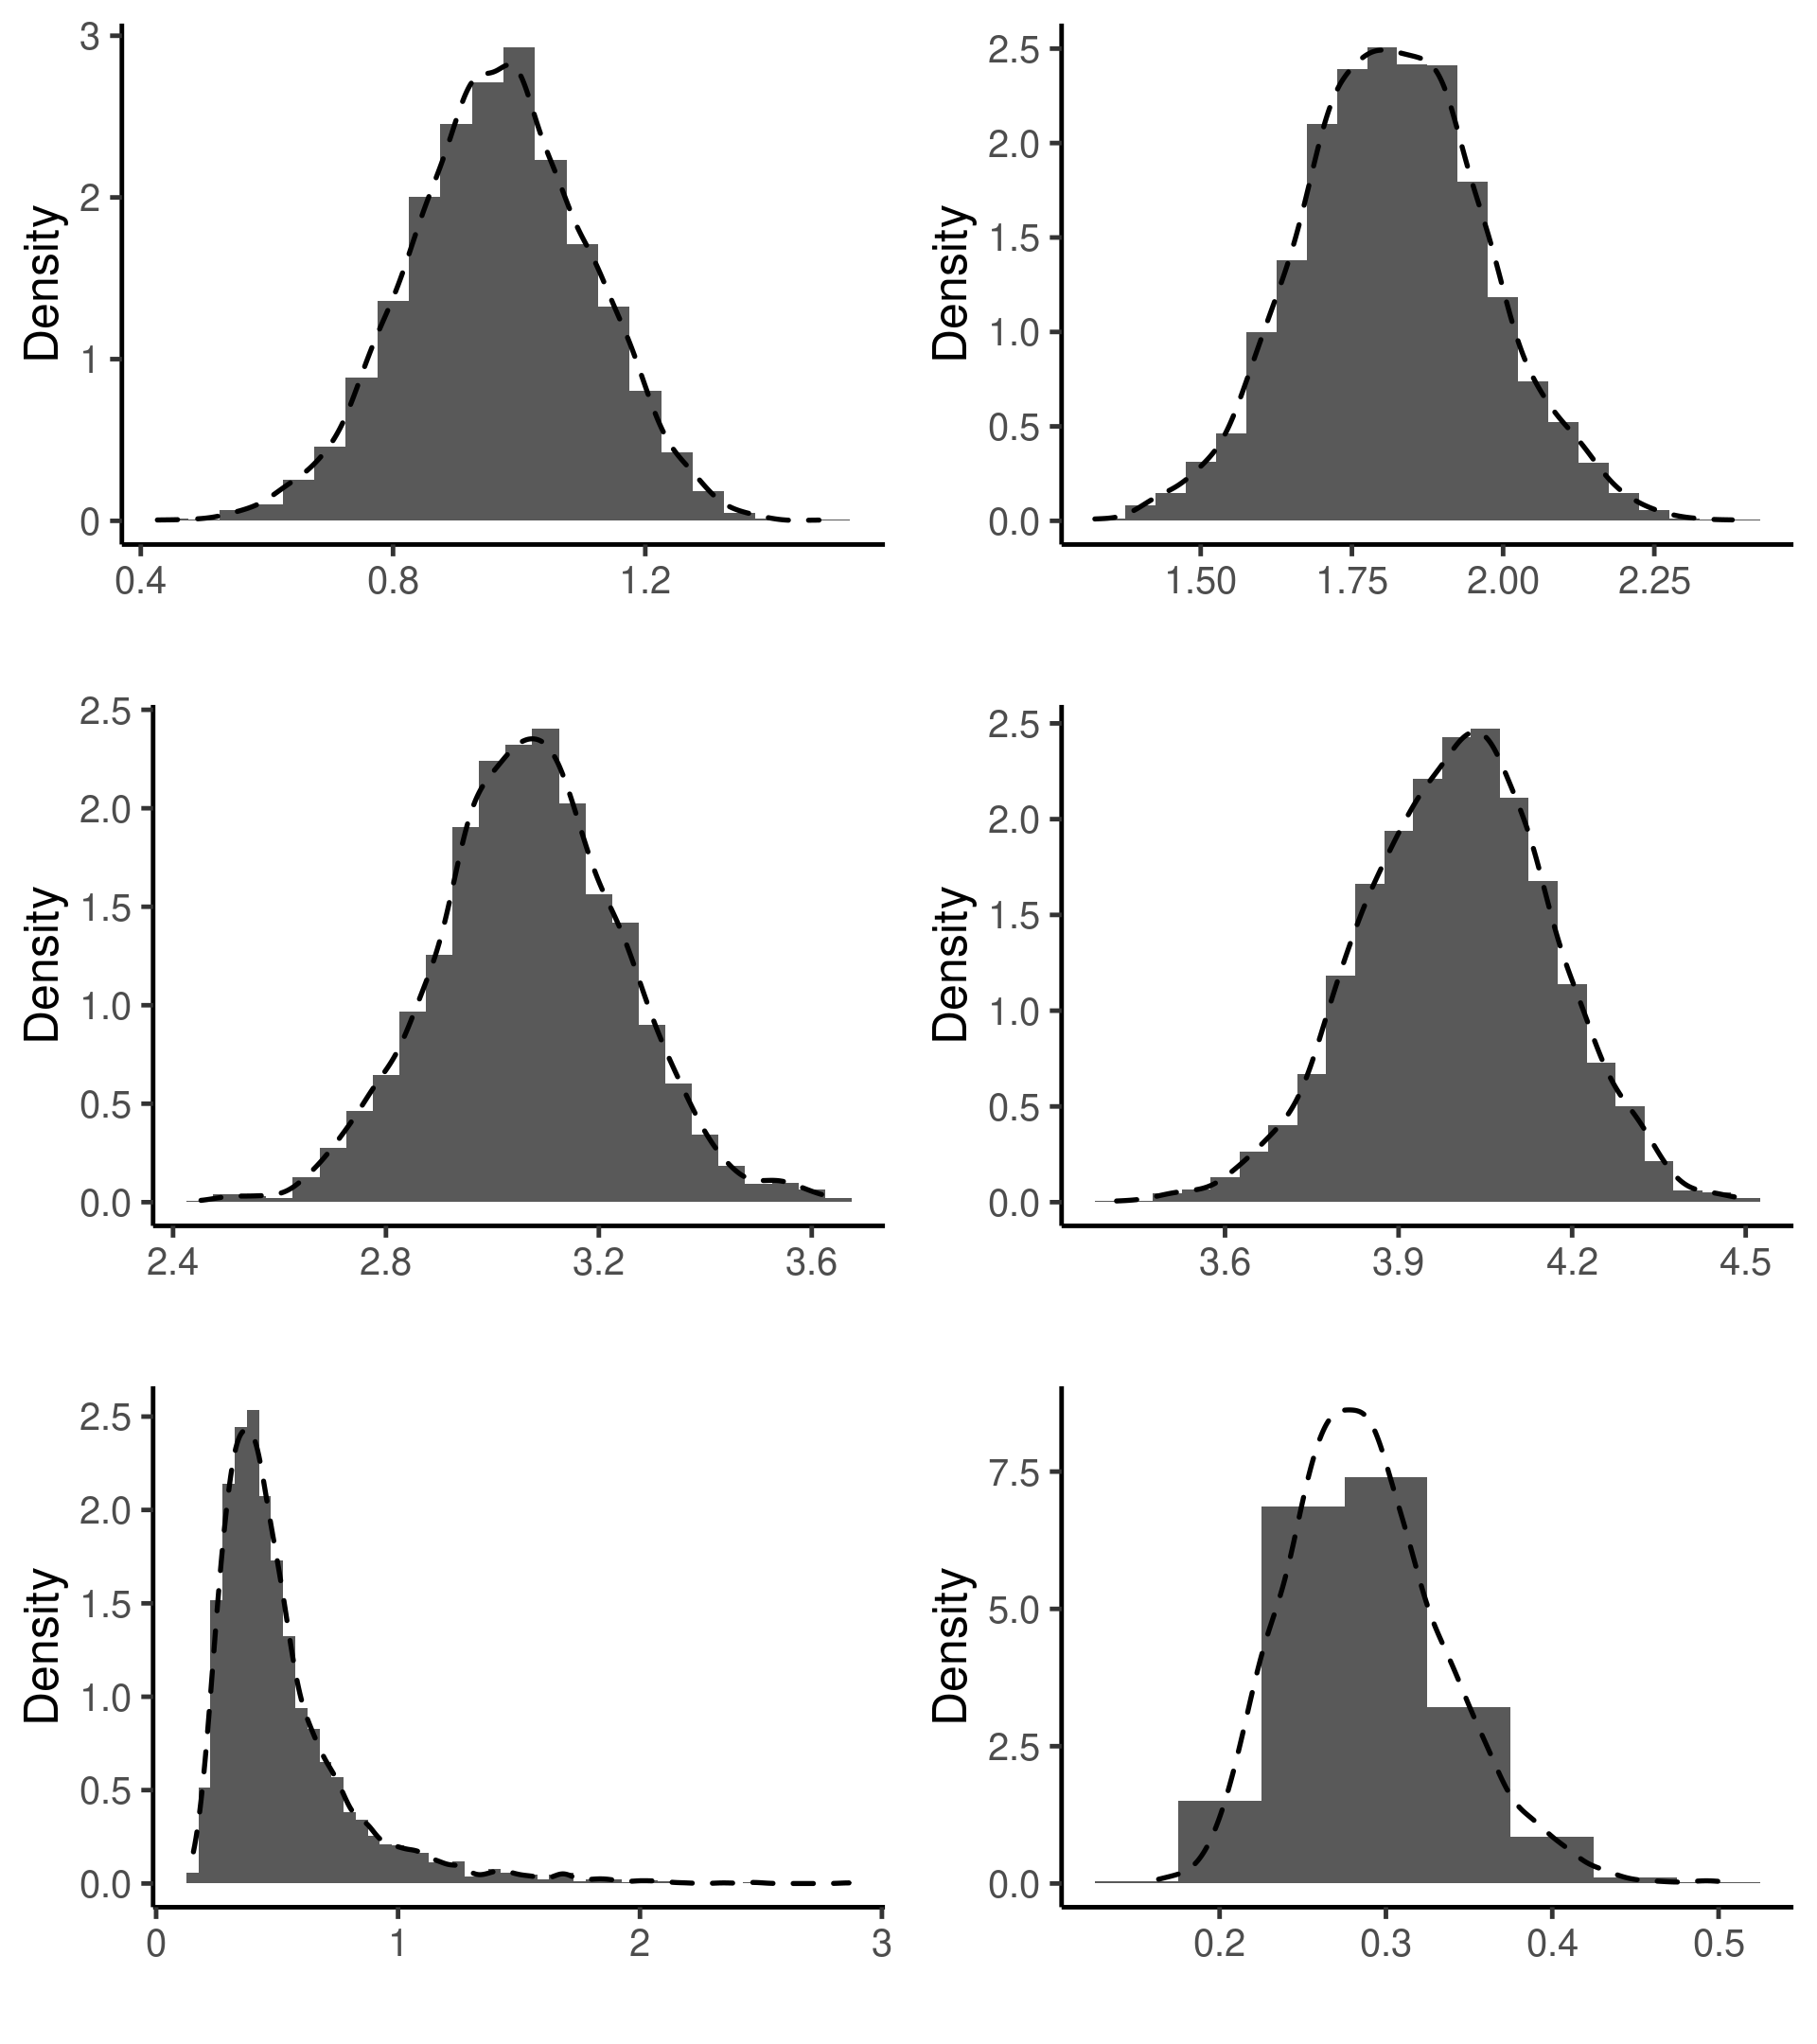

In [131]:
# Density
plt_density <- list(NULL)
for (i in 1:6) {
  # Get samples by parameter
  theta_i <- sapply(mcmc_res, function(x){x[, i]})
  if(i >= 5) theta_i <-1/theta_i # transform var to precision
    
  # Remove burn-in and thin samples
  theta_i <- theta_i[3000:nrow(theta_i), ]
  theta_i <- theta_i[seq(1, nrow(theta_i), 20), ] # Every 20th sample

  # Plot density (pre thinning)
  theta_i <- as.vector(theta_i) # combine chains
  plt_density[[i]] <- ggplot(data.frame(X = theta_i), aes(x = X, y=..density..)) + 
    geom_histogram(binwidth = 0.05) + 
    geom_density(size = 1.5, linetype = "dashed") + 
    ylab("Density") + 
    xlab("") +
    theme_classic(base_size = 30)
}#FOR

ggarrange(plt_density[[1]], plt_density[[2]], plt_density[[3]], 
          plt_density[[4]], plt_density[[5]], plt_density[[6]],
          nrow = 3, ncol = 2)